<a href="https://colab.research.google.com/github/markwreinke/OrganStopClassifier/blob/main/PytorchAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This initially is me following the tutorial at https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

It  will likely turn into my senior project

In [1]:
!pip install torchaudio # This allows me to run this in Google Colab
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend("sox_io")

     |████████████████████████████████| 7.6MB 2.7MB/s 
     |████████████████████████████████| 776.7MB 21kB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.7.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101


/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Shape of waveform: torch.Size([2, 276858])
Sample rate of waveform: 44100


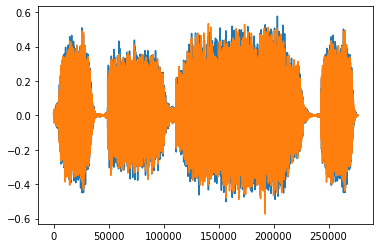

In [2]:
# This section is to open a file

#This gets a response object from an HTTP request
url = "https://pytorch.org/tutorials/_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
r = requests.get(url)

# Opening the wav file (more likely creating a wav file) and writing the content
# from the above HTTP response content
with open('steam-train-whistle-daniel_simon-converted-from-mp3.wav', 'wb') as f:
  f.write(r.content)

# saves the file name of the above created wav file, loading and audio file from the
# given file into a tensor named 'waveform' and an int representing its namesake of
# 'sample_rate'
# The waveform is represented as a tensor of size [CxL] or [LxC] where 
# L is the # of audio frames and C is the number of channels
filename = "steam-train-whistle-daniel_simon-converted-from-mp3.wav"
waveform, sample_rate = torchaudio.load(filename)

# This shows that there are 2 channels in the wave file (left, right)
# and 276858 audio frames (a bit more than 6 seconds of audio at 44100 samples per second)
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

# A visual of the file's waveform
plt.figure()
plt.plot(waveform.t().numpy())

Shape of spectrogram: torch.Size([2, 201, 1385])


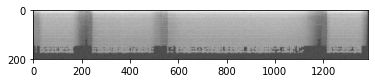

In [26]:
# look at the log of the spectrogram on a log scale
specgram = torchaudio.transforms.Spectrogram()(waveform) #This transforms the waveform into a spectrogram

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap = 'gray')

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape of spectrogram: torch.Size([2, 128, 1385])


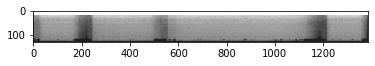

In [28]:
# Look at the Mel Spectrogram on a log scale

specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap = 'gray')

Shape of original waveform: torch.Size([1, 276858])
Shape of transformed waveform: torch.Size([1, 27686])


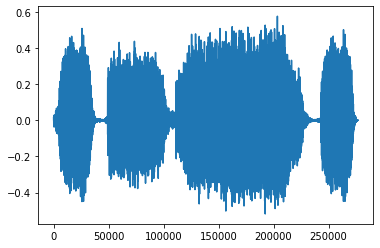

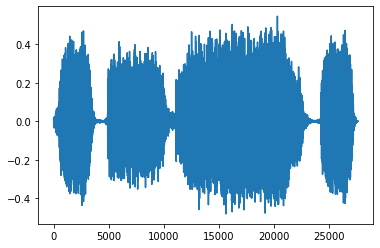

In [5]:
# Resample the waveform, one channel at a time

new_sample_rate = sample_rate/10
channel = 0

# This is to display the original waveform
transformed2 = torchaudio.transforms.Resample(sample_rate, sample_rate)(waveform[channel, :].view(1,-1))

# Since resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel, :].view(1,-1))
print("Shape of original waveform: {}".format(transformed2.size()))
print("Shape of transformed waveform: {}".format(transformed.size()))
plt.figure()
plt.plot(transformed2[0,:].numpy())


plt.figure()
plt.plot(transformed[0,:].numpy())

In [6]:
# Check if the tensor is in the interval [-1, 1]
print("Min of waveform: {}\nMax of waveform: {}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min of waveform: -0.572845458984375
Max of waveform: 0.575958251953125
Mean of waveform: 9.293758921558037e-05


In [8]:
# Sins the wave form is already between -1 and 1, we do not need to normalize it
def normalize(tensor):
  #Subtract the mean, and scale to the interval [-1, 1]
  tensor_minusmean = tensor - tensor.mean()
  return tensor_minusmean / tensor_minusmean.abs().max()

  # This would normalize it to the full interval [-1, 1], but as it is already in that range, we do not need to 
  # waveform = normalize(waveform)

Shape of transformed waveform: torch.Size([2, 276858])


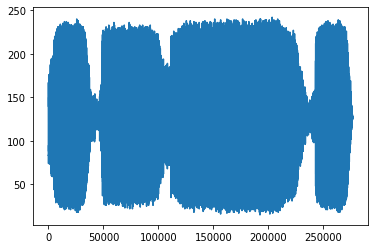

In [9]:
# Apply Mu-Law encoding to the waveform

transformed = torchaudio.transforms.MuLawEncoding()(waveform)

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())


Shape of recovered waveform: torch.Size([2, 276858])


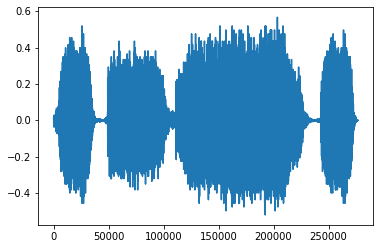

In [10]:
# Decode the Mu-Law encoding of the waveform
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

print("Shape of recovered waveform: {}".format(reconstructed.size()))

plt.figure()
plt.plot(reconstructed[0,:].numpy())

In [11]:
# Compare the original waveform with its reconstructed version
# Compute median relative difference
err = ((waveform-reconstructed).abs() / waveform.abs()).median()

print("Median relative difference between original and MuLaw reconstructed signals: {:.2%}".format(err))

Median relative difference between original and MuLaw reconstructed signals: 1.28%


Shape of transformed waveform:torch.Size([2, 276858])


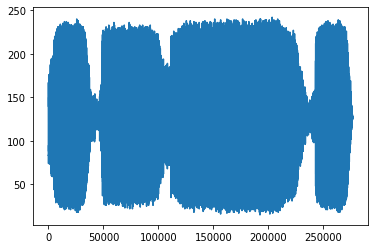

In [17]:
#Trying the mu_law_encoding functional
mu_law_encoding_waveform = torchaudio.functional.mu_law_encoding(waveform, quantization_channels=256)

print("Shape of transformed waveform:{}".format(mu_law_encoding_waveform.size()))

plt.figure()
plt.plot(mu_law_encoding_waveform[0, : ].numpy())

# The output from torchaudio.function.mu_law_encoding is the same as the output from torchaudio.transforms.MuLawEncoding

In [ ]:
# Taking the spectrogram, compute it's deltas
computed = torchaudio.functional.compute_deltas(specgram.contiguous(), win_length=3)
print("Shape of computed deltas: {}".format(computed.shape))

plt.figure()
plt.imshow(computed.log2()[0,:,:].detach().numpy(), cmap='gray')

In [21]:
# take the original waveform and apply different effects to it
gain_waveform = torchaudio.functional.gain(waveform, gain_db = 5.0)
print("Min of gain_waveform: {}\nMax of gain_waveform: {}\nMean of gain_waveform: {}".format(gain_waveform.min(), gain_waveform.max(), gain_waveform.mean()))

dither_waveform = torchaudio.functional.dither(waveform)
print("Min of dither_waveform: {}\nMax of dither_waveform: {}\nMean of dither_waveform: {}".format(dither_waveform.min(), dither_waveform.max(), dither_waveform.mean()))

Min of gain_waveform: -1.0186792612075806
Max of gain_waveform: 1.024214744567871
Mean of gain_waveform: 0.00016526902618352324
Min of dither_waveform: -0.572784423828125
Max of dither_waveform: 0.575927734375
Mean of dither_waveform: 0.00010744280007202178
